# Sheet 2

In [1]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['font.size'] = 9
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.figsize'] = (12 / 2.54, 7 / 2.54)

## Kernel Density Estimation

### (a)

In [2]:
def biweight(x, mu, w):
    """biweight kernel at mean mu, with bandwidth w evaluated at x"""
    mask = np.where(np.abs(x - mu) <= w, 1, 0)
    return mask * 15 / (16 * w) * (1 - ((x - mu) / w)**2)**2


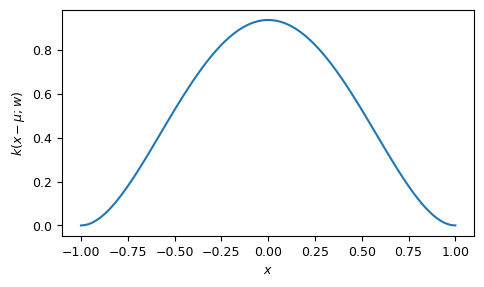

In [3]:
x = np.linspace(-1, 1, 100)

plt.plot(x, biweight(x, mu=0, w=1))
plt.xlabel('$x$')
plt.ylabel('$k(x-\\mu; w)$')
plt.show()

### (b)

In [4]:
# load the data
data = np.load("data/samples.npy")
data50 = data[:50]
print(f'{data.shape=}, {data50.shape=}')

data.shape=(10000,), data50.shape=(50,)


In [5]:
def kde(x, obs, w=1):
    """Kernel density estimate at x, with observations obs and bandwidth w"""
    mu = obs[:, np.newaxis] # Make column vector for broadcasting
    return np.mean(biweight(x, mu, w), axis=0)

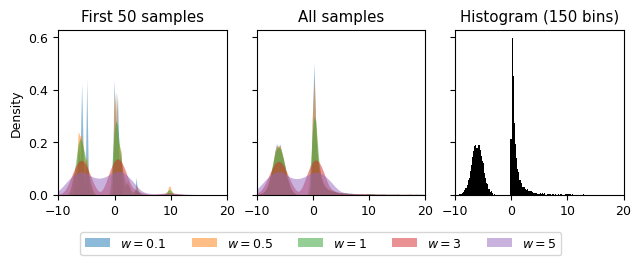

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16 / 2.54, 5.5 / 2.54), sharey=True)

x = np.linspace(-10, 20, 100)

ax1.set_title("First 50 samples")
ax2.set_title("All samples")
ax3.set_title("Histogram (150 bins)")

for w in (0.1, 0.5, 1, 3, 5):
    kde50 = kde(x, data50, w=w)
    kde_all = kde(x, data, w=w)
    ax1.fill_between(x, np.zeros_like(x), kde50, alpha=0.5, label=f"${w=}$")
    ax2.fill_between(x, np.zeros_like(x), kde_all, alpha=0.5)

ax3.hist(data, bins=150, density=True, color="k")

for ax in (ax1, ax2, ax3):
    ax.set_ylabel('Density')
    ax.set_xlim(-10, 20)
    ax.label_outer()

fig.legend(ncol=5, loc="center", bbox_to_anchor=(0.5, -0.1))

plt.show()

A larger bandwidth leads to a more smoothed out estimate. When it is too large though, details are lost (especially in the sharp second peak), but when it is too small, the randomness in the data is not smoothed out enough, as can be seen in the first plot with $w=0.1$. Increasing the number of samples leads to a higher resolution in the estimate, but the general shape remains the same. The optimal bandwidth depends on the data, so in the first case with only 50 samples, a bandwidth of $w=0.5$ or $w=1$ seems good, while in the second case with more data, it doesn't look too bad even with a bandwidth of $w=0.1$, as the noise is already quite low.

## Mean-Shift
### (a)
The update rule is given as
$$ \begin{aligned}
  x_j^{t+1} &= x_j^t + \alpha_j^t \frac{2}{n} \sum_i (x_i - x_j^t) \\
    &= x_j^t + \alpha_j^t \frac{2}{n} \sum_i x_i - \underbrace{\alpha_j^t \frac{2}{n} x_j^t \sum_i 1}_{\overset{!}{=} x_j^t}. \\
\end{aligned} $$
By choosing $\alpha_j^t$ such that
$$ \alpha_j^t = \frac{n}{2 \sum_i 1}, $$
we get the desired update rule
$$
  x_j^{t+1} = x_j^t + \Bigg(\frac{\sum_i x_i}{\sum_i 1} - x_j^t\Bigg) = \frac{\sum_i x_i}{\sum_i 1} = \text{Local Mean}.
$$

This is a sensible learning rate, because it depends on the density in the region. In high-density regions, the gradient can be large, so we want to take smaller steps to not overshoot the maximum. In low-density regions, the gradient is small, so we can take larger steps to get to the maximum faster.

### (b)

In [7]:
def mean_shift_step(x, xt, r=1):
    """
    A single step of mean shift, moving every point in xt to the local mean of points in x within a radius of r.
    
    Parameters
    ----------
    x : np.ndarray
        Array of points underlying the KDE, shape (d, N1)
    xt : np.ndarray
        Current state of the mean shift algorithm, shape (d, N2)
    r : float
        Radius of the local mean
        
    Returns
    -------
    np.ndarray
        the points after the mean-shift step, shape (d, N2)
    """

    assert xt.shape[0] == x.shape[0], f'Shape mismatch: {x.shape[0]}!={xt.shape[0]}'

    # transpose as it is easier to work in that way, so now
    # - x is of shape (N1, d)
    # - xt is of shape (N2, d)
    x = x.T
    xt = xt.T
    
    # dists and mask are of shape (N1, N2)
    dists = np.linalg.norm(x[:, None] - xt, axis=2)
    mask = (dists < r).astype(int)

    # (sum_i mask_ij * x_i) / (sum_i mask_ij)
    # |                   |   |             |
    # \----- (N2, d) -----/   \-- (N2, 1) --/
    numerator = np.einsum('ij,id->jd', mask, x)
    denominator = np.sum(mask, axis=0)[:, np.newaxis]

    # local_means is of shape (N2, d)
    local_means = numerator / denominator
    
    # returned array is of shape (d, N2)
    return local_means.T
    

#### Non-Blurring case

I had to reshape the `x` and `xt` to the shape `(d, N)` required by the above update rule.

Converged after 14 steps to 7 unique points:
[-6.14867943 -5.78314475  0.43767061  5.31920715  7.03753737  9.85259047
 11.46206139]


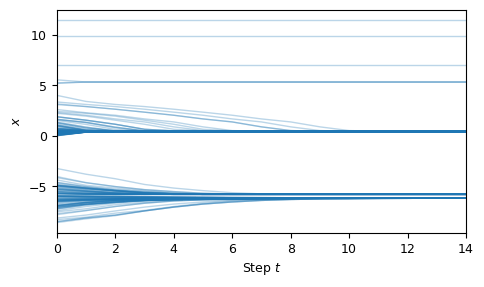

In [8]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

# convert from shape (N,) to (1, N)
x = x.reshape(1, -1)
xt = xt.reshape(1, -1)

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    xt = mean_shift_step(x, xt, r=1)
    trajectories.append(xt)
    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break

trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1

unique = np.unique(trajectories[-1])
print(f'Converged after {n_steps} steps to {unique.size} unique points:')
print(unique)

plt.plot(trajectories[:, 0, :], c='C0', lw=1, alpha=0.3)
plt.xlabel('Step $t$')
plt.ylabel('$x$')
plt.xlim(0, n_steps)
plt.show()

#### Blurring case

Converged after 6 steps to 8 unique points:
[-7.4781409  -5.99590454  0.52258634  2.20433551  5.31920715  7.03753737
  9.85259047 11.46206139]


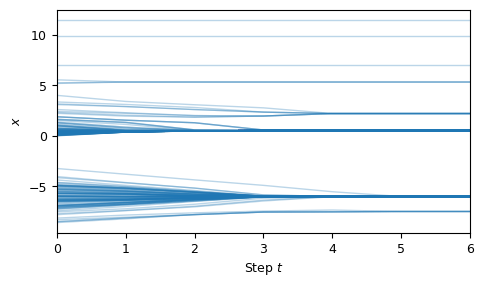

In [9]:
# load the data
data = np.load("data/samples.npy")
x = data[:200]  # use e.g. the first 200 points
xt = x

# convert from shape (N,) to (1, N)
x = x.reshape(1, -1)
xt = xt.reshape(1, -1)

trajectories = [xt]
max_steps = 100
for step in range(max_steps):
    xt = mean_shift_step(xt, xt, r=1) # <-- Replaced x with xt
    trajectories.append(xt)
    if np.allclose(trajectories[-1], trajectories[-2]):  # break in case of convergence
        break

trajectories = np.stack(trajectories)
n_steps = len(trajectories) - 1

unique = np.unique(trajectories[-1])
print(f"Converged after {n_steps} steps to {unique.size} unique points:")
print(unique)

plt.plot(trajectories[:, 0, :], c='C0', lw=1, alpha=0.3)
plt.xlabel('Step $t$')
plt.ylabel('$x$')
plt.xlim(0, n_steps)
plt.show()

The convergence behaviour is different in the blurring case, as the local means are separated earlier leading to more clusters in the end. The single-element clusters at high $x$ are the same in both cases, but the larger clusters show some differences, although not too large. In both cases (but especially in the case without blurring), there are two rather close clusters at large negative values of $x$, which should probably ideally be a single cluster.

## Linear Regression: Heteroscedastic Noise

Start by converting the problem to a homoscedastic one by transforming the data:
$$
  y^\prime_n = \frac{y_n}{\sigma_n} = \beta^T \, \frac{x_n}{\sigma_n} + \frac{\varepsilon_n}{\sigma_n}.
$$
When defining $x^\prime_n = x_n / \sigma_n$ and $\varepsilon^\prime_n = \varepsilon_n / \sigma_n$ the expectation value and variance of $\varepsilon^\prime_n$ are
$$
  \mathbb{E}[\varepsilon^\prime_n] = 0, \quad \mathrm{Var}[\varepsilon^\prime_n] = 1 = \text{const.}\ ,
$$
thus fulfilling the homoscedasticity condition. The sum-of-squares problem then reads
$$
  \mathrm{SSQ} = \sum_n \left(y^\prime_n - \beta^T x^\prime_n \right)^2 = \sum_n \frac{1}{\sigma_n^2} \left(y_n - \beta^T x_n \right)^2,
$$
which corresponds to weighing each data point by the inverse of its variance. To solve this problem, we introduce the diagonal weight matrix $W_{nn} = 1 / \mathrm{Var}[\varepsilon_n] = 1/\sigma_n^2$ and rewrite the sum-of-squares as
$$ \begin{aligned}
  \mathrm{SSQ} &= (y - X^T \beta)^T W (y - X^T \beta) \\
  \partial_\beta \mathrm{SSQ} &= -2 y^T W X^T + 2 \beta^T X W X^T \overset{!}{=} 0.
\end{aligned} $$

Solving this for $\beta$ gives
$$
  \hat{\beta} = (X W X^T)^{-1} X W y.
$$
Given that and $\mathrm{Cov}[\varepsilon] = W^{-1}$, we can calculate the covariance of $\hat{\beta}$ as
$$ \begin{aligned}
  \mathrm{Cov}[\hat{\beta}] &= \mathrm{Cov}[(X W X^T)^{-1} X W (X^T \beta + \varepsilon)] \\
    &= \mathrm{Cov}[(X W X^T)^{-1} X W \varepsilon] \\
    &= (X W X^T)^{-1} X W \, \mathrm{Cov}[\varepsilon] \, W X^T (X W X^T)^{-1} \\
    &= (X W X^T)^{-1} \\
\end{aligned} $$
